# Model Validation: How to Know How Much Your Model Knows

- Matthew Emery - Senior Data Scientist @ Imbellus Inc.
- www.matthewemery.ca
- Find the code at https://github.com/lstmemery/lunch-and-learn-validation

## What Are We Covering?

- Quick explainer on Fashion MNIST and Decision Trees
 - Overfitting Explanation
 - The Golden Rule of Machine Learning
 - Optimization Bias and Cross-Validation

In [6]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import gzip
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from math import log, sqrt
from pathlib import Path
import numpy as np
import bokeh.plotting as bk
import graphviz

fmnist_class_names = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat",
                    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

%matplotlib inline

In [7]:
with gzip.open(Path("data", "train-labels-idx1-ubyte.gz")) as label_path:
    labels = np.frombuffer(label_path.read(), dtype=np.uint8,
                           offset=8)

with gzip.open(Path("data", "train-images-idx3-ubyte.gz")) as image_path:
    features = np.frombuffer(image_path.read(), 
                           dtype=np.uint8, 
                           offset=16).reshape(len(labels), 784)
    

<Figure size 432x288 with 0 Axes>

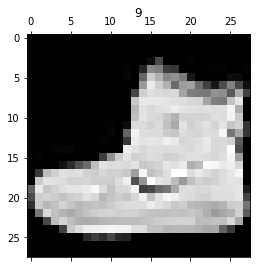

In [8]:
plt.gray() 
plt.matshow(features[0].reshape((28,28))) 
plt.title(labels[0])
plt.show() # This is the data we're dealing with

- When I first wrote this tutorial I used MNIST
- Then I found out about Fashion MNIST
- Benefits:
    1. Harder than MNIST
    2. Less used than MNIST
    3. Better represents modern computer vision tasks
- How many of you have heard of MNIST?


In [9]:
(train_features, validation_features,
 train_labels, validation_labels) = train_test_split(
    features,
    labels,
    random_state=0,
    shuffle=True,
    test_size=0.20, # This is fine enough
    stratify=labels
)

## A Quick Explainer on Decision Trees

In [23]:
graph_data = export_graphviz(models[1],
                            filled=True,
                            rounded=True,
                            class_names=fmnist_class_names)
graph = graphviz.Source(graph_data, format="png")
graph.render("decision_tree", "img")

'img/decision_tree.png'

![](img/decision_tree.png)

- A decision tree is trained by looking at each pixel value and seeing what breakpoint would split classes the best
- Pick the best pixel to split on and continue
- The size of the tree is a hyperparameter
- I decided to choose a decision tree to illustrate this for a couple of reasons
  1. Decision Trees are really easy to understand
  2. No need to do any preprocessing
  3. It shows that even very simple models can do simple computer vision tasks

In [10]:
models, train_scores = [], []
for depth in range(1, 20):
    model = DecisionTreeClassifier(
        max_depth=depth,
    random_state=0)
    model.fit(train_features, train_labels)
    score = model.score(train_features, train_labels)
    print(depth, round(score, 2))
    models.append(model)
    train_scores.append(score)

1 0.2
2 0.36
3 0.5
4 0.65
5 0.71
6 0.74
7 0.78
8 0.81
9 0.83
10 0.85
11 0.87
12 0.89
13 0.91
14 0.93
15 0.94
16 0.96
17 0.97
18 0.98
19 0.98


In [7]:
validation_scores = []

for depth, model in enumerate(models):
    score = model.score(test_features, test_labels)
    print(depth, round(score, 2))
    validation_scores.append(score)

0 0.2
1 0.36
2 0.5
3 0.65
4 0.71
5 0.73
6 0.76
7 0.78
8 0.8
9 0.81
10 0.81
11 0.81
12 0.82
13 0.81
14 0.81
15 0.81
16 0.81
17 0.81
18 0.8


In [8]:
plot_1 = bk.figure(title="Training vs. Validation Accuracy",
    )
plot_1.xaxis.axis_label = "Depth"
plot_1.yaxis.axis_label = "Accruacy"
plot_1.line(x = range(1, 20), y = train_scores, line_width = 5, color = "blue", legend = "Training Accuracy")
plot_1.line(x = range(1, 20), y = validation_scores, line_width = 5, color = "orange", legend = "Validation Accuracy")
bk.show(plot_1)

## Overfitting

- The gap between training and validation accuracy is **overfitting**
 - **Interpretation**: Our model has memorized part of the data set instead of learning the underlying rules
 - If the validation accuracy was higher than our training that's **underfitting**

## Think About Studying for an Exam

- Training your model is like the model reviewing its notes
 - Validation is when you take the midterm

### Golden Rule of Machine Learning

- The test cannot influence training in any way
- If you know the answers on the exam ahead of time, you won't know if you actually learned the material

# Common Mistakes

- Making many models and choosing the one that does best on the test set
 - Time Series: Incorporating information from the future in your model (i.e. quarterly results before end of quarter)
 - Imputing based on the combined train-test dataset

## Should Just Fit a Million Models Until I Find Something?

### No

## An Illustration

- Sign up for my service and I'll email you a prediction of whether or not the S&P goes up or down that morning
 - Every work day for two week days I'm right
 - **What do you need to ask me before you should trust my model?**

## How Many Other People Did I Send Emails to?

- Two business weeks is 10 business days
$$2^{10} = 1024$$
- If I sent 1024 people different emails (Up, Down, Up etc.) I'm guarenteed to be right once

## The Same Thing Happens With Machine Learning Models

- We call this **optimization bias**
 - Sometimes you find something that fits your validation data set through dumb luck

## How do we decrease the Effect of Optimization Bias?

- **Cross-validation** (or repeated cross-validation)
- Leave a **test set** that you evaluate very rarely (one a week or less)
- Set a limit to the number of models you will evaluate

## Cross-Validation

![https://bradleyboehmke.github.io/hands-on-machine-learning-with-r/regression-performance.html](img/cross-validation.png)

In [30]:
cv_scores = []
for depth in range(1, 20):
    model = DecisionTreeClassifier(
        max_depth=depth,
    random_state=0)
    
    cv_score = cross_val_score(
        model,
        features,
        labels,
        cv = 5,
        n_jobs = -1
    )
    
    print("Depth:", depth,
          "Mean:", round(np.mean(cv_score), 2), 
          "SD:", round(np.std(cv_score), 3))
    
    cv_scores.append(cv_score)

Depth: 1 Mean: 0.2 SD: 0.0
Depth: 2 Mean: 0.36 SD: 0.002
Depth: 3 Mean: 0.5 SD: 0.003
Depth: 4 Mean: 0.65 SD: 0.002
Depth: 5 Mean: 0.71 SD: 0.003
Depth: 6 Mean: 0.73 SD: 0.003
Depth: 7 Mean: 0.76 SD: 0.003
Depth: 8 Mean: 0.79 SD: 0.002
Depth: 9 Mean: 0.8 SD: 0.002
Depth: 10 Mean: 0.81 SD: 0.003
Depth: 11 Mean: 0.81 SD: 0.004
Depth: 12 Mean: 0.81 SD: 0.003
Depth: 13 Mean: 0.81 SD: 0.003
Depth: 14 Mean: 0.81 SD: 0.002
Depth: 15 Mean: 0.81 SD: 0.003
Depth: 16 Mean: 0.81 SD: 0.004
Depth: 17 Mean: 0.81 SD: 0.004
Depth: 18 Mean: 0.81 SD: 0.004
Depth: 19 Mean: 0.81 SD: 0.005


In [32]:
rcv_scores = []
for depth in range(1, 20):
    model = DecisionTreeClassifier(
        max_depth=depth,
    random_state=0)
    
    rcv = RepeatedStratifiedKFold(
        n_splits = 5,
        n_repeats = 5,
        random_state = 0
    )
    
    rcv_score = cross_val_score(
        model,
        features,
        labels,
        cv = rcv,
        n_jobs = -1
    )
    
    print("Depth:", depth,
          "Mean:", round(np.mean(rcv_score), 2), 
          "SD:", round(np.std(rcv_score), 3))
    
    rcv_scores.append(rcv_score)

Depth: 1 Mean: 0.2 SD: 0.0
Depth: 2 Mean: 0.36 SD: 0.002
Depth: 3 Mean: 0.5 SD: 0.004
Depth: 4 Mean: 0.65 SD: 0.004
Depth: 5 Mean: 0.71 SD: 0.004
Depth: 6 Mean: 0.73 SD: 0.003
Depth: 7 Mean: 0.77 SD: 0.004
Depth: 8 Mean: 0.79 SD: 0.003
Depth: 9 Mean: 0.8 SD: 0.003
Depth: 10 Mean: 0.81 SD: 0.003
Depth: 11 Mean: 0.81 SD: 0.003
Depth: 12 Mean: 0.81 SD: 0.003
Depth: 13 Mean: 0.81 SD: 0.003
Depth: 14 Mean: 0.81 SD: 0.003
Depth: 15 Mean: 0.81 SD: 0.004
Depth: 16 Mean: 0.81 SD: 0.003
Depth: 17 Mean: 0.81 SD: 0.003
Depth: 18 Mean: 0.81 SD: 0.003
Depth: 19 Mean: 0.8 SD: 0.003


## Summary

- Always create a validation set (cross-validation if you have a small amount of data)
 - Never let information from your validation set leak into to your training
 - Don't train models for no reason

## Bibliography

